In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## 加载数据集

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os

np.random.seed(2018)

n = 25000
image_datas = np.zeros((n, 300, 300, 3), dtype=np.uint8)
# X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
# y = np.zeros((n, 1), dtype=np.uint8)
# 获得当前目录
current_dir = os.getcwd()
for i in tqdm(range(12500)):
    image_datas[i] = cv2.resize(cv2.imread(current_dir + '/data/train/cat/cat.%d.jpg' % i, cv2.IMREAD_COLOR), 
                                (300, 300))
    image_datas[i + 12500] = cv2.resize(cv2.imread(current_dir + '/data/train/dog/dog.%d.jpg' % i, cv2.IMREAD_COLOR), 
                                        (300, 300))


# y[n/2:] = 1
image_datas.shape

100%|██████████| 12500/12500 [02:50<00:00, 73.40it/s]


(25000, 300, 300, 3)

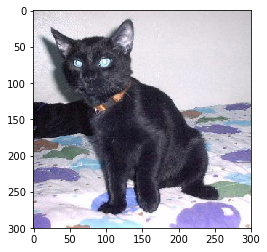

Size =  (300, 300, 3)


In [17]:
plt.imshow(image_datas[843], cmap='gray')
plt.show()
print("Size = ", image_datas[843].shape)

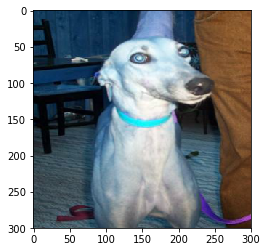

Size =  (300, 300, 3)


In [18]:
plt.imshow(image_datas[21000], cmap='gray')
plt.show()
print("Size = ", image_datas[21000].shape)

## 分为训练集和验证集

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py

In [ ]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 训练模型

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

## 可视化模型

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [ ]:
zip([x.name for x in model.layers], range(len(model.layers)))

In [ ]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[172].output, model.output])

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [ ]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])

# Fine-tune

http://keras-cn.readthedocs.io/en/latest/blog/image_classification_using_very_little_data/

In [ ]:
for layer in model.layers[140:]:
    layer.trainable = True

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))